In [1]:
!which python

/home/milad/milad/1/TEZ/3esp32/2tflight/3voice-controlled-robot/model/venv/bin/python


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.python.ops import gen_audio_ops as audio_ops

2023-07-29 09:32:42.195968: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-29 09:32:51.339993: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-29 09:32:51.367951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 09:33:07.289888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
SPEECH_DATA='speech_data'

In [4]:
# The audio is all sampled at 16KHz and should all be 1 second in length - so 1 second is 16000 samples
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be abover the noise floor?
MINIMUM_VOICE_LENGTH=EXPECTED_SAMPLES/4

In [5]:
# list of folders we want to process in the speech_data folder
command_words = [
    'forward',
    'backward',
    'left',
    'right',
    '_invalid',
]
nonsense_words = [
    'stop',
    'go',
    'on',
    'off',
    'up',
    'down',
    'learn',
    'yes',
    'no',
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five',
    'six',
    'seven',
    'eight',
    'nine',
    'follow',
    'tree',
    'bed',
    'bird',
    'cat',
    'dog',
    'happy',
    'house',
    'marvin',
    'sheila',
    'visual',
    'wow',
]

In [6]:
# get all the files in a directory
def get_files(word):
    return gfile.glob(SPEECH_DATA + '/'+word+'/*.wav')

# get the location of the voice
def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)

# Work out how much of the audio file is actually voice
def get_voice_length(audio, noise_floor):
    position = get_voice_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()

# is enough voice present?
def is_voice_present(audio, noise_floor, required_length):
    voice_length = get_voice_length(audio, noise_floor)
    return voice_length >= required_length

# is the audio the correct length?
def is_correct_length(audio, expected_length):
    return (audio.shape[0]==expected_length).numpy()


def is_valid_file(file_name):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    # check the file is long enough
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # is there any voice in the audio?
    if not is_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    return True


In [7]:
def get_spectrogram(audio):
    # normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    # reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram

In [8]:
# process a file into its spectrogram
def process_file(file_path):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # randomly reposition the audio in the sample
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    # add some random background noise
    background_volume = np.random.uniform(0, 0.1)
    # get the background noise files
    background_files = get_files('_background_noise_')
    background_file = np.random.choice(background_files)
    background_tensor = tfio.audio.AudioIOTensor(background_file)
    background_start = np.random.randint(0, len(background_tensor) - 16000)
    # normalise the background noise
    background = tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
    background = background - np.mean(background)
    background = background / np.max(np.abs(background))
    # mix the audio with the scaled background
    audio = audio + background_volume * background
    # get the spectrogram
    return get_spectrogram(audio)

In [9]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [ ]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label) for file_name in tqdm(file_names, desc=f"{word} ({label})", leave=False)]

# process the files for a word into the spectrogram and one hot encoding word value
def process_word(word, label, repeat=1):
    # get a list of files names for the word
    file_names = [file_name for file_name in tqdm(get_files(word), desc="Checking", leave=False) if is_valid_file(file_name)]
    print(file_names)
    # randomly shuffle the filenames
    np.random.shuffle(file_names)
    # split the files into train, validate and test buckets
    train_size=int(TRAIN_SIZE*len(file_names))
    validation_size=int(VALIDATION_SIZE*len(file_names))
    test_size=int(TEST_SIZE*len(file_names))
    print(train_size, validation_size, test_size)
    # get the training samples
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # and the validation samples
    validate.extend(
        process_files(
            file_names[train_size:train_size+validation_size],
            label,
            repeat=repeat
        )
    )
    # and the test samples
    test.extend(
        process_files(
            file_names[train_size+validation_size:],
            label,
            repeat=repeat
        )
    )

# process all the command words
for word in tqdm(command_words, desc="Processing words"):
    print(word)
    if '_' not in word:
        repeat = 40 if word in ('forward','backward') else 20
        # print(repeat)
        process_word(word, command_words.index(word), repeat=repeat)
        
# all the nonsense words
for word in tqdm(nonsense_words, desc="Processing words"):
    if '_' not in word:
        process_word(word, command_words.index('_invalid'), repeat=1)

print(len(train), len(test), len(validate))

In [12]:
print("TensorFlow I/O version:", tfio.__version__)
print("TensorFlow:", tf.__version__)
print("numpy:", np.__version__)

TensorFlow I/O version: 0.32.0
TensorFlow: 2.12.0
numpy: 1.22.4


In [ ]:
!pip freeze

In [ ]:
# process the background noise files
def process_background(file_name, label):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 16000), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    # simulate random utterances
    for section_index in tqdm(range(1000), desc="Simulated Words", leave=False):
        section_start = np.random.randint(0, audio_length - EXPECTED_SAMPLES)
        section_end = section_start + EXPECTED_SAMPLES
        section = np.reshape(audio[section_start:section_end], (EXPECTED_SAMPLES))

        result = np.zeros((EXPECTED_SAMPLES))
        # create a pseudo bit of voice
        voice_length = np.random.randint(MINIMUM_VOICE_LENGTH/2, EXPECTED_SAMPLES)
        voice_start = np.random.randint(0, EXPECTED_SAMPLES - voice_length)
        hamming = np.hamming(voice_length)
        # amplify the voice section
        result[voice_start:voice_start+voice_length] = hamming * section[voice_start:voice_start+voice_length]
        # get the spectrogram
        spectrogram = get_spectrogram(np.reshape(section, (16000, 1)))
        samples.append((spectrogram, label))
        
    
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])

    validate.extend(samples[train_size:train_size+validation_size])

    test.extend(samples[train_size+validation_size:])

        
for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    process_background(file_name, command_words.index("_invalid"))
    
print(len(train), len(test), len(validate))

In [ ]:
def process_problem_noise(file_name, label):
    samples = []
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 800), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))
        
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_problem_noise_"), desc="Processing problem noise"):
    process_problem_noise(file_name, command_words.index("_invalid"))

In [16]:
print(len(train), len(test), len(validate))

251443 31576 31374


In [17]:
# randomise the training samples
np.random.shuffle(train)

In [18]:
X_train, Y_train = zip(*train)
X_validate, Y_validate = zip(*validate)
X_test, Y_test = zip(*test)

In [19]:
# save the computed data
np.savez_compressed(
    "training_spectrogram.npz",
    X=X_train, Y=Y_train)
print("Saved training data")
np.savez_compressed(
    "validation_spectrogram.npz",
    X=X_validate, Y=Y_validate)
print("Saved validation data")
np.savez_compressed(
    "test_spectrogram.npz",
    X=X_test, Y=Y_test)
print("Saved test data")

Saved training data
Saved validation data
Saved test data


In [20]:
# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [21]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(2, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    

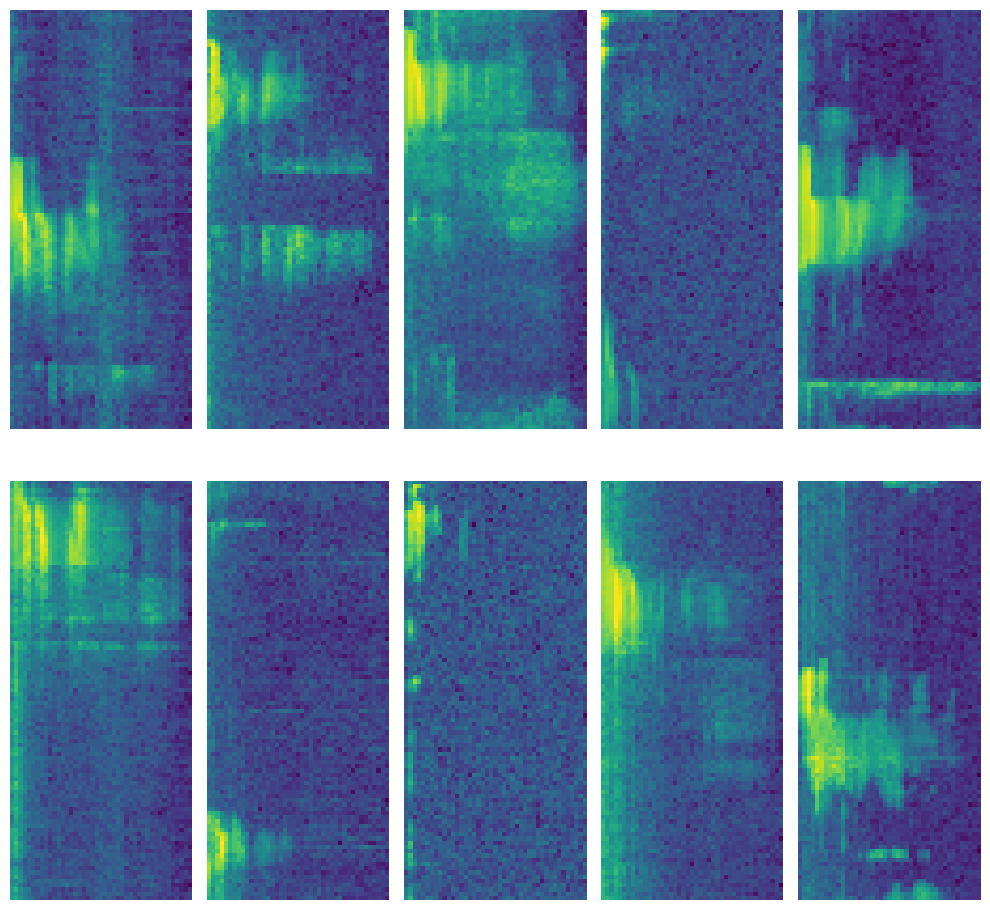

In [22]:
word_index = command_words.index("left")

X_left = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_left[:10], IMG_WIDTH, IMG_HEIGHT)

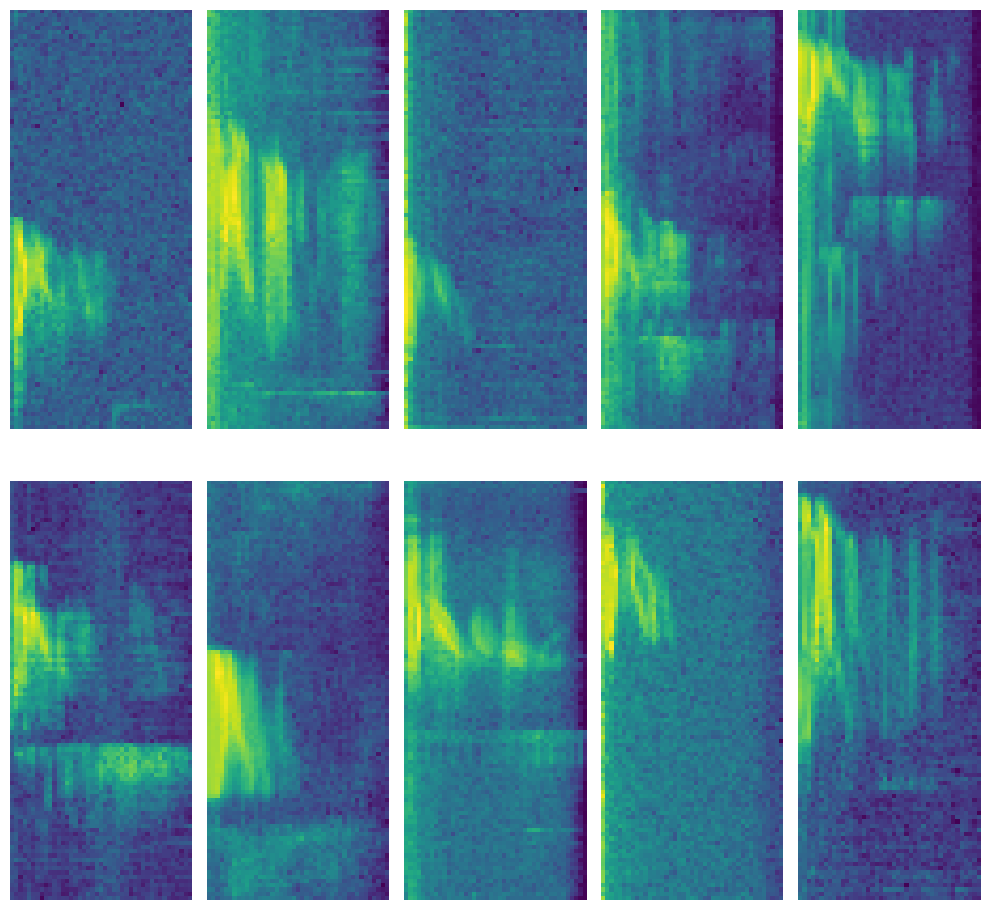

In [23]:
word_index = command_words.index("right")

X_right = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_right[:10], IMG_WIDTH, IMG_HEIGHT)